封装算法包：

get_maxs_weight

get_mvar_weight

get_target_risk_weight

get_target_return_weight

get_target_averse_weight

plot_efficent_frontier

2022-07-28新增:

get_maxs_weight、get_mvar_weight、get_target_risk_weight、get_target_return_weight、get_target_averse_weight、plot_efficent_frontier增加返回值

get_target_risk_weight、get_target_return_weight 增加返回值条件




In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.interpolate as sci
import pyodbc

In [2]:
def get_return(df):
    # 计算收益率（对数形式）
    df = df/df.iloc[0]*100 # 统一缩放到100为基点
    log_ret = np.log(df/df.shift())
    log_ret.dropna(inplace=True)
    stock_number = log_ret.shape[1]
    return log_ret,stock_number



In [3]:
def statistics(weights,expected_return,ret_cov,rf):
    '''
    本次计算，期望收益率均使用历史平均收益率
    '''
    weights = np.array(weights)
    pret = np.sum(expected_return * weights*252) 
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret_cov*252 , weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])


In [4]:
def min_func_sharpe(weights,expected_return,ret_cov,rf):
    return -statistics(weights,expected_return,ret_cov,rf)[2]
def min_func_variance(weights,expected_return,ret_cov,rf):
    return statistics(weights,expected_return,ret_cov,rf)[1] ** 2
def min_func_return(weights,expected_return,ret_cov,rf):
    return -statistics(weights,expected_return,ret_cov,rf)[0]
def risk_averse(weights,expected_return,ret_cov,rf,lamb):
    return -statistics(weights,expected_return,ret_cov,rf)[0]+lamb*statistics(weights,expected_return,ret_cov,rf)[1]**2

In [5]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf
'''
def get_maxs_weight(df,bnds,rf):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    fun=min_func_sharpe
    opt = sco.minimize(fun,x0=stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                   bounds=bnds, constraints=cons)
    return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf)

In [6]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf
'''
def get_mvar_weight(df,bnds,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    fun=min_func_variance
    opt = sco.minimize(fun,x0=stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                   bounds=bnds, constraints=cons)
    return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf)

In [7]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf)
增加返回条件：与目标值不可偏差超过1E-8
'''
def get_target_risk_weight(df,bnds,target_risk,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'eq', 'fun': lambda x:  -statistics(x,expected_return,ret_cov,rf)[1] + target_risk},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    fun=min_func_return
    opt = sco.minimize(fun,x0=stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                   bounds=bnds, constraints=cons)
    #--------------------20220728修改
    if abs(statistics(opt['x'],expected_return,ret_cov,rf)[1]-target_risk)>1e-8:
        print('无法找到最优解')
    else:
        return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf)
    #--------------------
    

In [8]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf)
增加返回条件：与目标值不可偏差超过1E-8
'''
def get_target_return_weight(df,bnds,target_return,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x,expected_return,ret_cov,rf)[0] - target_return},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    opt = sco.minimize(min_func_variance, stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                           bounds=bnds, constraints=cons,tol=0.001)
    #--------------------20220728修改
    if abs(statistics(opt['x'],expected_return,ret_cov,rf)[0]-target_return)>1e-8:
        print('无法找到最优解')
    else:
        return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf)
    #------------------------
   

In [9]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf),-risk_averse(opt['x'],expected_return,ret_cov,rf,lamb)
'''
def get_target_averse_weight(df,bnds,lamb,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    opt = sco.minimize(risk_averse, stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf,lamb), method='SLSQP',
                           bounds=bnds, constraints=cons)
    
 
    return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf),-risk_averse(opt['x'],expected_return,ret_cov,rf,lamb)
    
   
    
   

In [10]:
'''
有效边界中增加返回值：每个点对应的res['x']
'''
def min_func_port(weights,expected_return,ret_cov,rf):
    return statistics(weights,expected_return,ret_cov,rf)[1]

def plot_efficent_frontier(df,bnds,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
   # prets,pvols=get_distribution(log_ret)
    ret_min=min(log_ret.mean()*252)
  
    ret_max=max(log_ret.mean()*252)

    trets = np.linspace(ret_min,ret_max,50)
    tvols = []
    stats=[]
    for tret in trets:
        cons = ({'type': 'eq', 'fun': lambda x:  statistics(x,expected_return,ret_cov,rf)[0] - tret},
                {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
        bnds = bnds
        res = sco.minimize(min_func_port, x0=stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                           bounds=bnds, constraints=cons)
        
       # print(statistics(res['x'],expected_return,ret_cov,rf)[0]-tret)
        if abs(statistics(res['x'],expected_return,ret_cov,rf)[0]-tret)>1e-8:
            
            return
          
        tvols.append(res['fun'])
       #----------------20220728新增
        stats.append(res['x'])
        
        #--------------------------
    tvols = np.array(tvols)
    ind = np.argmin(tvols)
    #if len(tvols)==len(trets):
    evols = tvols[ind:]  # 有效边界
    erets = trets[ind:]  # 有效边界
    #tck = sci.splrep(evols, erets)  # 有效边界插值
    plt.scatter(evols, erets,marker='x')

                # efficient frontier
    plt.grid(True)
   # plt.axhline(0, color='k', ls='--', lw=2.0)
  #  plt.axvline(0, color='k', ls='--', lw=2.0)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
     #----------------20220728新增stats[ind:]

    return evols,erets,stats[ind:]
    
  



------------测试样例，不用封装

In [12]:
def read_data(BeginDate,EndDate):
    sql_conn = pyodbc.connect('''DRIVER={SQL Server Native Client 11.0};SERVER=10.101.0.213; DATABASE=JYDB;Trusted_Connection=yes''') 

    dfQuery='''
    select a.TradingDay,a.ClosePrice HS300,c.ClosePrice CYBZ from QT_IndexQuote  a  
    join QT_IndexQuote c on  a.TradingDay=c.TradingDay
    where a.InnerCode=3145  and c.InnerCode=16899 and a.TradingDay between '{}' and '{}'

    '''.format(pd.to_datetime(BeginDate),pd.to_datetime(EndDate))
    df=pd.read_sql(dfQuery,sql_conn,index_col='TradingDay')
    return df


In [13]:
BeginDate='2021-7-18'
EndDate='2021-8-18'
df=read_data(BeginDate,EndDate)
bnds = tuple((0, 1) for _ in range(df.shape[1]))

In [87]:
#优化目标1：最大夏普
rf=0
print("优化目标1：最大夏普:",get_maxs_weight(df,bnds,rf))
#优化目标2：最小波动率
print("优化目标2：最小波动率:",get_mvar_weight(df,bnds))
#优化目标3：给定波动率，最大化收益率
target_risk=0.1
print("优化目标3：给定波动率，最大化收益率:",get_target_risk_weight(df,bnds,target_risk))
#优化目标4：给定收益，最小化波动率
target_return=0.4
print("优化目标4：给定收益，最小化波动率:",get_target_return_weight(df,bnds,target_return))
#优化目标5：给定风险厌恶系数
lamb=0
print("优化目标5：给定风险厌恶系数:",get_target_averse_weight(df,bnds,lamb))

优化目标1：最大夏普: (array([0.4, 0.6]), array([0.0239082 , 0.34450105, 0.06939948]))
优化目标2：最小波动率: (array([0.5, 0.5]), array([0.02086964, 0.34352463, 0.06075151]))
无法找到最优解
优化目标3：给定波动率，最大化收益率: None
无法找到最优解
优化目标4：给定收益，最小化波动率: None
优化目标5：给定风险厌恶系数: (array([0.4, 0.6]), array([0.0239082 , 0.34450105, 0.06939948]), 0.023908195538995043)


(array([0.22004111, 0.22011007, 0.22028028, 0.22055152, 0.22092341,
        0.22139545, 0.22196699, 0.22263726, 0.22340539, 0.22427036,
        0.22523105, 0.22628626, 0.22743466, 0.22867485, 0.23000534,
        0.23142458, 0.23293095, 0.23452276, 0.23619829, 0.23795578,
        0.23979341, 0.24170935, 0.24370178, 0.24576881, 0.2479086 ,
        0.25011926, 0.25239894, 0.25474578, 0.25715795, 0.25963363,
        0.26217101]),
 array([-0.19705967, -0.18101081, -0.16496195, -0.14891309, -0.13286423,
        -0.11681537, -0.10076651, -0.08471765, -0.06866879, -0.05261993,
        -0.03657107, -0.02052221, -0.00447335,  0.01157551,  0.02762437,
         0.04367322,  0.05972208,  0.07577094,  0.0918198 ,  0.10786866,
         0.12391752,  0.13996638,  0.15601524,  0.1720641 ,  0.18811296,
         0.20416182,  0.22021068,  0.23625954,  0.2523084 ,  0.26835726,
         0.28440612]),
 [array([0.6122449, 0.3877551]),
  array([0.59183673, 0.40816327]),
  array([0.57142857, 0.42857143]),
  arra

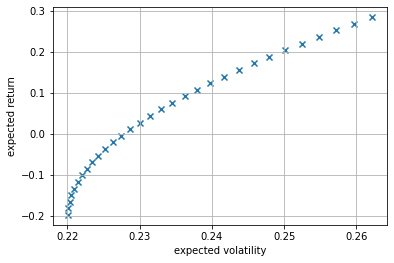

In [14]:
plot_efficent_frontier(df,bnds)

In [89]:
BeginDate='2021-1-31'
EndDate='2022-3-31'
df=read_data(BeginDate,EndDate)
bnds = tuple((0, 1) for _ in range(df.shape[1]))

In [90]:
#优化目标1：最大夏普
rf=0.01
print("优化目标1：最大夏普:",get_maxs_weight(df,bnds,rf))
#优化目标2：最小波动率
print("优化目标2：最小波动率:",get_mvar_weight(df,bnds))
#优化目标3：给定波动率，最大化收益率
target_risk=0.24
print("优化目标3：给定波动率，最大化收益率:",get_target_risk_weight(df,bnds,target_risk))
#优化目标4：给定收益，最小化波动率
target_return=0
print("优化目标4：给定收益，最小化波动率:",get_target_return_weight(df,bnds,target_return))
#优化目标5：给定风险厌恶系数
lamb=-0.3
print("优化目标5：给定风险厌恶系数:",get_target_averse_weight(df,bnds,lamb))

优化目标1：最大夏普: (array([0., 1.]), array([0.0754586 , 0.31468711, 0.2080117 ]))
优化目标2：最小波动率: (array([0.77987655, 0.22012345]), array([-0.15355264,  0.27451542, -0.5593589 ]))
无法找到最优解
优化目标3：给定波动率，最大化收益率: None
优化目标4：给定收益，最小化波动率: (array([0.25696726, 0.74303274]), array([9.33058700e-11, 2.93257218e-01, 3.18170754e-10]))
优化目标5：给定风险厌恶系数: (array([0., 1.]), array([0.0754586 , 0.31468711, 0.23978929]), 0.10516699310365826)


(array([0.27451677, 0.27455892, 0.27466009, 0.2748202 , 0.27503915,
        0.27531681, 0.275653  , 0.2760475 , 0.27650006, 0.2770104 ,
        0.2775782 , 0.27820311, 0.27888474, 0.27962268, 0.28041649,
        0.28126569, 0.28216978, 0.28312824, 0.28414051, 0.28520602,
        0.28632419, 0.28749439, 0.28871598, 0.28998833, 0.29131077,
        0.29268262, 0.29410318, 0.29557175, 0.29708763, 0.29865009,
        0.3002584 , 0.30191184, 0.30360966, 0.30535112, 0.30713549,
        0.30896201, 0.31082995, 0.31273856, 0.31468711]),
 array([-0.15227046, -0.14627759, -0.14028472, -0.13429185, -0.12829898,
        -0.12230611, -0.11631324, -0.11032037, -0.1043275 , -0.09833463,
        -0.09234176, -0.08634889, -0.08035602, -0.07436315, -0.06837028,
        -0.06237741, -0.05638454, -0.05039167, -0.0443988 , -0.03840593,
        -0.03241306, -0.02642019, -0.02042732, -0.01443445, -0.00844158,
        -0.00244871,  0.00354416,  0.00953703,  0.0155299 ,  0.02152277,
         0.02751564,  0.0335

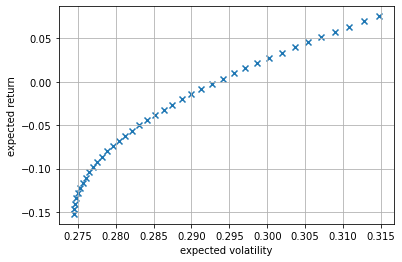

In [91]:
plot_efficent_frontier(df,bnds)

In [92]:
BeginDate='2021-1-31'
EndDate='2021-6-30'
df=read_data(BeginDate,EndDate)
bnds = tuple((0, 1) for _ in range(df.shape[1]))

In [93]:
#优化目标1：最大夏普
rf=0
print("优化目标1：最大夏普:",get_maxs_weight(df,bnds,rf))
#优化目标2：最小波动率
print("优化目标2：最小波动率:",get_mvar_weight(df,bnds))
#优化目标3：给定波动率，最大化收益率
target_risk=0.2
print("优化目标3：给定波动率，最大化收益率:",get_target_risk_weight(df,bnds,target_risk))
#优化目标4：给定收益，最小化波动率
target_return=0.1
print("优化目标4：给定收益，最小化波动率:",get_target_return_weight(df,bnds,target_return))
#优化目标5：给定风险厌恶系数
lamb=1
print("优化目标5：给定风险厌恶系数:",get_target_averse_weight(df,bnds,lamb))

优化目标1：最大夏普: (array([0., 1.]), array([0.28577557, 0.17950817, 1.59199202]))
优化目标2：最小波动率: (array([0.30689781, 0.69310219]), array([0.16905738, 0.17271067, 0.97884737]))
优化目标3：给定波动率，最大化收益率: (array([0.93944846, 0.06055154]), array([-0.07151182,  0.2       , -0.35755909]))
优化目标4：给定收益，最小化波动率: (array([0.48847672, 0.51152328]), array([0.1       , 0.17512022, 0.57103627]))
优化目标5：给定风险厌恶系数: (array([0., 1.]), array([0.28577557, 0.17950817, 1.59199202]), 0.2535523865977972)


(array([0.17271071, 0.17274369, 0.17283792, 0.17299332, 0.17320971,
        0.17348687, 0.1738245 , 0.17422226, 0.17467973, 0.17519645,
        0.17577189, 0.17640548, 0.17709659, 0.17784456, 0.17864867,
        0.17950817]),
 array([0.16935227, 0.17711382, 0.18487538, 0.19263693, 0.20039848,
        0.20816004, 0.21592159, 0.22368314, 0.2314447 , 0.23920625,
        0.2469678 , 0.25472936, 0.26249091, 0.27025246, 0.27801402,
        0.28577557]),
 [array([0.30612245, 0.69387755]),
  array([0.28571429, 0.71428571]),
  array([0.26530612, 0.73469388]),
  array([0.24489796, 0.75510204]),
  array([0.2244898, 0.7755102]),
  array([0.20408163, 0.79591837]),
  array([0.18367347, 0.81632653]),
  array([0.16326531, 0.83673469]),
  array([0.14285714, 0.85714286]),
  array([0.12244898, 0.87755102]),
  array([0.10204082, 0.89795918]),
  array([0.08163265, 0.91836735]),
  array([0.06122449, 0.93877551]),
  array([0.04081633, 0.95918367]),
  array([0.02040816, 0.97959184]),
  array([0., 1.])])

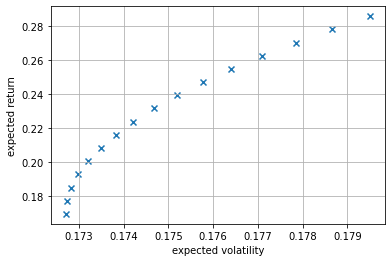

In [94]:
plot_efficent_frontier(df,bnds)